In [27]:
import os
import torch
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
label_class = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
class_label = {v: k for k, v in label_class.items()}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESIZE = 48
BATCH_SIZE = 128
PATH = 'D:\AI Courses\Semester 3\Computer Vision\Term Project\model'

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'Model': {
        'train':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        transforms.ToTensor(),
        normalize
    ])
    },
    'Others': {
        'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])
    }
}

In [4]:
train_base_path = 'images/train/'
val_base_path = 'images/validation/'

classes = list(label_class.values())

tr_paths, tr_lbls = [], []
val_paths, val_lbls = [], []

for each in classes:

    full_path = train_base_path + each + '/'
    num_items = os.listdir(full_path)
    for itm in num_items:
        tr_paths.append(full_path + itm)
        tr_lbls.append(class_label[each])
        
    full_path = val_base_path + each + '/'
    num_items = os.listdir(full_path)
    for itm in num_items:
        val_paths.append(full_path + itm)
        val_lbls.append(class_label[each])


tr_dict = {'img_id': tr_paths, 'label':tr_lbls}
val_dict = {'img_id': val_paths, 'label':val_lbls}

tr_df = pd.DataFrame(tr_dict)
val_df = pd.DataFrame(val_dict)

del tr_dict, val_dict, tr_lbls, val_lbls, tr_paths, val_paths, classes

In [5]:
tr_df.head()

,img_id,label
0,images/train/angry/0.jpg,0
1,images/train/angry/1.jpg,0
2,images/train/angry/10.jpg,0
3,images/train/angry/10002.jpg,0
4,images/train/angry/10016.jpg,0


In [6]:
val_df.head()

,img_id,label
0,images/validation/angry/10052.jpg,0
1,images/validation/angry/10065.jpg,0
2,images/validation/angry/10079.jpg,0
3,images/validation/angry/10095.jpg,0
4,images/validation/angry/10121.jpg,0


Text(0.5, 1.0, 'Emotion Classes and Their Number of Samples')

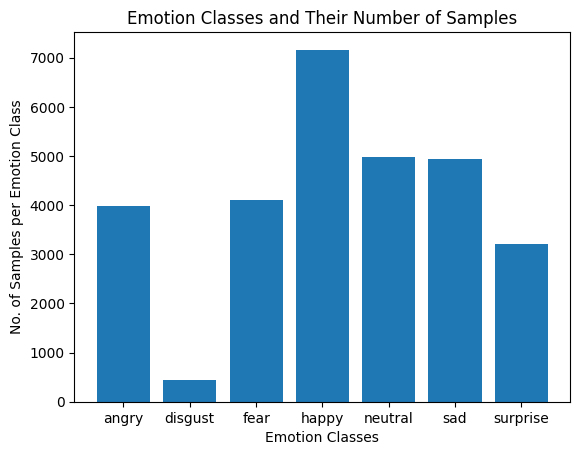

In [7]:
plt.bar(list(label_class.values()), list(tr_df['label'].value_counts().sort_index()))
plt.xlabel("Emotion Classes") 
plt.ylabel("No. of Samples per Emotion Class") 
plt.title("Emotion Classes and Their Number of Samples") 

In [8]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None, shuffle_data=True):

        self.df = df
        self.transform = transform
        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        img = Image.open(self.df.iloc[idx, 0]).convert("RGB")
        lbl = self.df.iloc[idx, 1]

        if self.transform:
            img = self.transform(img)

        return img, lbl

In [9]:
tr_model_dt = ImageDataset(tr_df, data_transforms['Model']['train'])
val_model_dt = ImageDataset(val_df, data_transforms['Model']['other'])
tr_other_dt = ImageDataset(tr_df, data_transforms['Others']['train'])
val_other_dt = ImageDataset(val_df, data_transforms['Others']['other'])

tr_model_loader = DataLoader(tr_model_dt, batch_size=BATCH_SIZE, shuffle=True)
val_model_loader = DataLoader(val_model_dt, batch_size=BATCH_SIZE, shuffle=True)
tr_other_loader = DataLoader(tr_other_dt, batch_size=BATCH_SIZE, shuffle=True)
val_other_loader = DataLoader(val_other_dt, batch_size=BATCH_SIZE, shuffle=True)

dataloaders = {
    'Model': {
        'train': tr_model_loader,
        'validation': val_model_loader
    },
    'Others': {
        'train': tr_other_loader,
        'validation': val_other_loader
    }
}

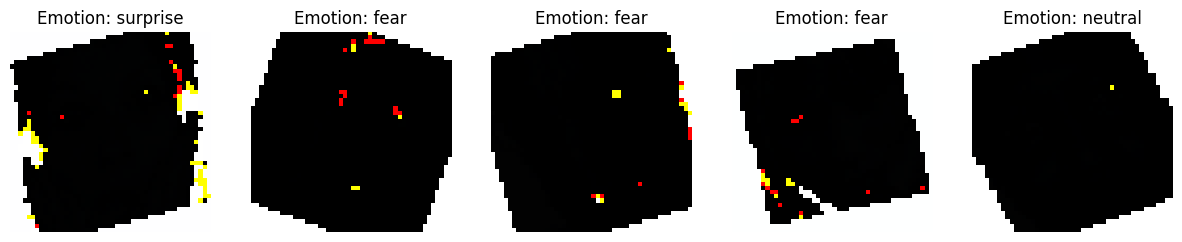

In [10]:
num_samples = 5
random_indices = np.random.randint(0, len(tr_model_dt), num_samples)

# Plot the images
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

for i, idx in enumerate(random_indices):
    image, label = tr_model_dt[idx]
    image = image.permute(1, 2, 0)
    axes[i].imshow(np.uint8(np.array(image)))
    axes[i].set_title(f"Emotion: {label_class[label]}")
    axes[i].axis('off')

plt.show()

In [11]:
del tr_model_loader, val_model_loader, tr_model_dt, val_model_dt, tr_other_loader, val_other_loader, tr_other_dt, val_other_dt

In [12]:
class Model(nn.Module):
    def __init__(self, num_features):
        
        super(Model, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_features, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )
        
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 256, True),
            nn.BatchNorm1d(256),
            nn.Dropout1d(0.1),
            nn.Linear(256, 128, True),
            nn.BatchNorm1d(128),
            nn.Dropout1d(0.1),
            nn.Linear(128, 7, True),
        )


    
    def forward(self, x):

        # print(x.shape)
        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)

        return x

In [13]:
def train_model(data, model, criterion, optimizer, num_epochs=3, return_loss_acc=True):
    
    if return_loss_acc:
        tr_val_history = {'train': [], 'validation': []}
        tr_val_acc_history = {'train': [], 'validation': []}
    
    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(data[phase], unit='batch', position=0, leave=True) as pbar:
                for img, lbl in pbar:

                    pbar.set_description(f"Epoch {epoch+1}")

                    img = img.to(device)
                    lbl = lbl.to(device)
                    outputs = model(img)
                    loss = criterion(outputs, lbl)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = (torch.max(outputs, 1))
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == lbl.data)
                    pbar.set_postfix(loss=loss.item() / BATCH_SIZE, accuracy=torch.sum(preds == lbl.data).item() / BATCH_SIZE)

            epoch_loss = running_loss / len(data[phase])
            epoch_acc = running_corrects.double() / len(data[phase])

            if return_loss_acc:
                tr_val_history[phase].append(epoch_loss)
                tr_val_acc_history[phase].append(epoch_acc.item())
            
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
    if return_loss_acc:
        return model, (tr_val_history, tr_val_acc_history)
    return model

In [13]:
model = Model(3).to(device)
opt = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

EPOCH = 30

model_trained, history = train_model(dataloaders['Model'], model, criterion, opt, EPOCH)

In [14]:
def plot_loss_acc(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history[0]['train'], label='Train Loss')
    plt.plot(history[0]['validation'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history[1]['train'], label='Train Accuracy')
    plt.plot(history[1]['validation'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.legend()

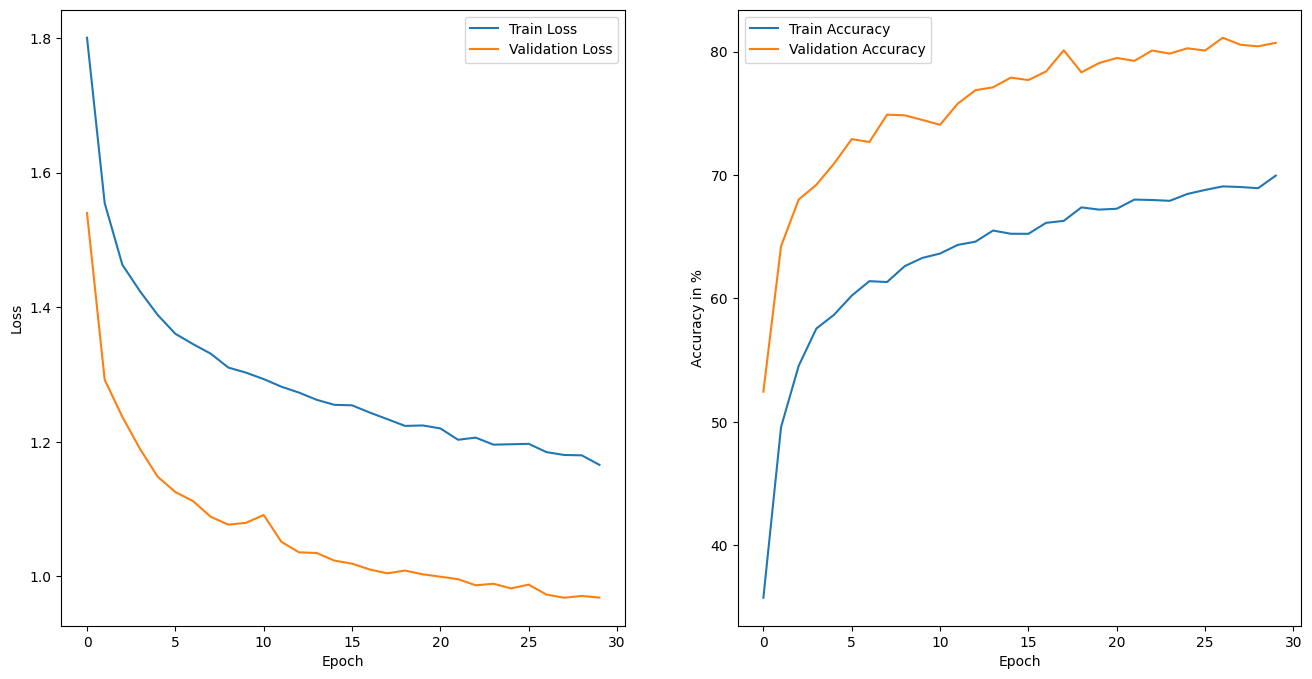

In [17]:
plot_loss_acc(history)

In [29]:
# torch.save(model_trained, './model/model.pth')

In [15]:
def renderer(model, data):

    face_classifier = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
    model.eval()
    model.to(device)



    cap = cv.VideoCapture(0)

    while True:
        _, frame = cap.read()
        faces = face_classifier.detectMultiScale(frame)
        for (x,y,w,h) in faces:
            cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
            roi = frame[y:y + h, x:x + w]
            roi = cv.resize(roi, (48, 48), interpolation=cv.INTER_AREA)



            if np.sum([roi]) != 0:
                roi = data['other'](Image.fromarray(roi))
                roi = roi.reshape((1, roi.shape[0], roi.shape[1], roi.shape[2])).to(device)
                prediction = model(roi)
                label = label_class[torch.max(prediction, 1).indices.item()]
                label_position = (x, y)
                cv.putText(frame, label, label_position, cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else:
                cv.putText(frame, 'No Faces', (30, 80), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        cv.imshow('Emotion Detector',frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv.destroyAllWindows()

In [26]:
PATH = './model/model.pth'
model = torch.load(PATH)
renderer(model, data_transforms['Model'])

In [17]:
resnet = models.resnet18(weights='DEFAULT')

for param in resnet.parameters():
    param.requires_grad = False
    
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet.fc.in_features, 7),
    nn.Softmax(dim=1)
)
resnet = resnet.to(device)


EPOCH = 30
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr = 0.001)

resnet_trained, history = train_model(dataloaders['Others'], resnet, criterion, opt, EPOCH)

--------------------------------------------------
Epoch 1/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8746, acc: 34.2168


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8677, acc: 33.7143
--------------------------------------------------
Epoch 2/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8524, acc: 37.5000


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8393, acc: 39.2857
--------------------------------------------------
Epoch 3/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8456, acc: 38.5752


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8447, acc: 37.5714
--------------------------------------------------
Epoch 4/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8445, acc: 38.6372


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8346, acc: 38.5893
--------------------------------------------------
Epoch 5/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8406, acc: 39.1504


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8273, acc: 40.9821
--------------------------------------------------
Epoch 6/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8404, acc: 39.3097


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8348, acc: 38.6429
--------------------------------------------------
Epoch 7/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8406, acc: 38.9558


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8387, acc: 38.3929
--------------------------------------------------
Epoch 8/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8366, acc: 39.8496


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8256, acc: 40.5714
--------------------------------------------------
Epoch 9/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8364, acc: 39.7611


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8306, acc: 39.0893
--------------------------------------------------
Epoch 10/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8356, acc: 39.6726


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8278, acc: 39.8393
--------------------------------------------------
Epoch 11/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8321, acc: 39.9912


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8276, acc: 39.9643
--------------------------------------------------
Epoch 12/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8330, acc: 40.3717


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8409, acc: 38.1429
--------------------------------------------------
Epoch 13/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8318, acc: 40.1460


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8249, acc: 40.4821
--------------------------------------------------
Epoch 14/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8323, acc: 40.0708


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8313, acc: 39.5357
--------------------------------------------------
Epoch 15/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8314, acc: 40.1726


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8352, acc: 39.0714
--------------------------------------------------
Epoch 16/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8352, acc: 39.6062


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8265, acc: 40.1071
--------------------------------------------------
Epoch 17/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8331, acc: 39.9823


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8246, acc: 41.0357
--------------------------------------------------
Epoch 18/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8324, acc: 40.1681


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8229, acc: 41.2500
--------------------------------------------------
Epoch 19/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8297, acc: 40.6372


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8245, acc: 40.2143
--------------------------------------------------
Epoch 20/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8323, acc: 40.0531


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8311, acc: 39.9107
--------------------------------------------------
Epoch 21/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8330, acc: 40.1106


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8229, acc: 41.2857
--------------------------------------------------
Epoch 22/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8366, acc: 39.6681


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8105, acc: 43.1429
--------------------------------------------------
Epoch 23/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8340, acc: 39.9425


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8125, acc: 42.5179
--------------------------------------------------
Epoch 24/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8325, acc: 40.2389


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8068, acc: 43.4464
--------------------------------------------------
Epoch 25/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8305, acc: 40.4027


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8221, acc: 41.3036
--------------------------------------------------
Epoch 26/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8293, acc: 40.6858


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8095, acc: 43.6071
--------------------------------------------------
Epoch 27/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8315, acc: 40.4779


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8208, acc: 41.5536
--------------------------------------------------
Epoch 28/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8335, acc: 39.9602


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8199, acc: 41.4643
--------------------------------------------------
Epoch 29/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8320, acc: 40.2655


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8424, acc: 38.4464
--------------------------------------------------
Epoch 30/30
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.8315, acc: 40.3938


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.8147, acc: 42.1607


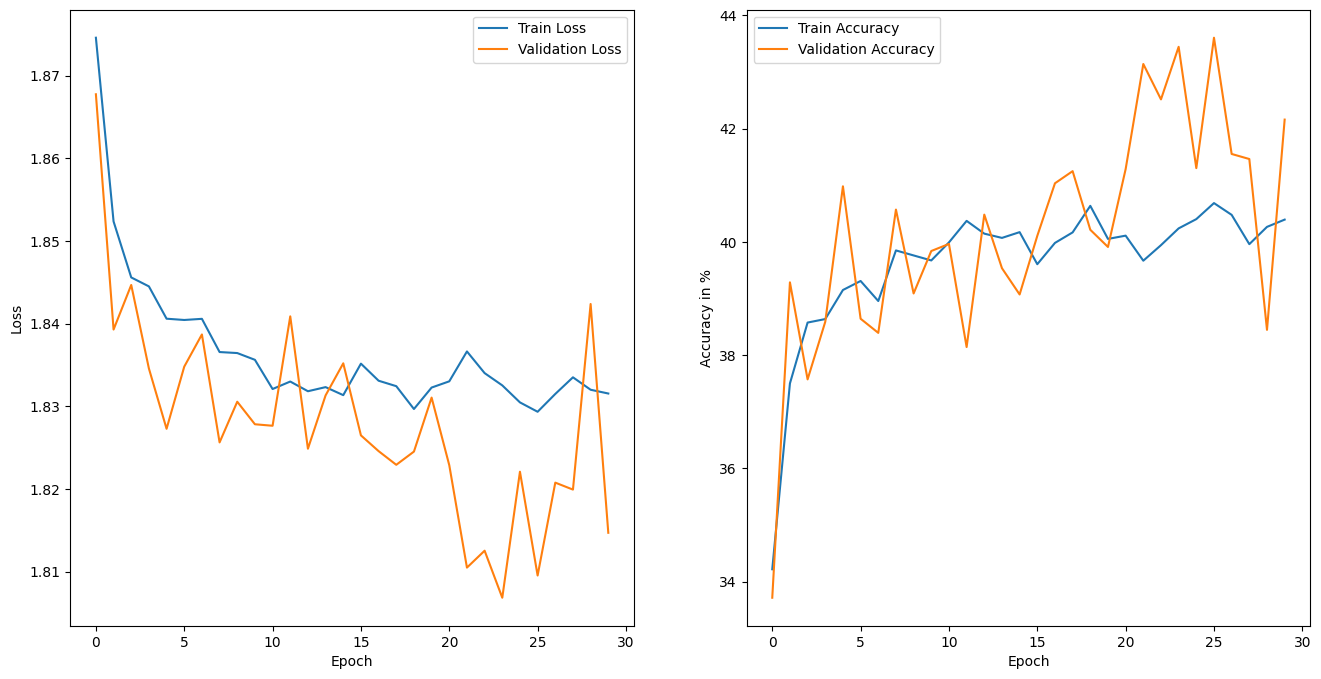

In [18]:
torch.save(resnet_trained, './model/resnet.pth')
plot_loss_acc(history)

In [27]:
PATH = './model/resnet.pth'
resnet = torch.load(PATH)
renderer(resnet, data_transforms['Others'])

In [15]:
model = models.vgg11_bn(weights='DEFAULT')
for params in model.parameters():
    params.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=7, bias=True))

model = model.to(device)


opt = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

EPOCH = 10
model_trained, history = train_model(dataloaders['Others'], model, criterion, opt, EPOCH)

--------------------------------------------------
Epoch 1/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.6561, acc: 52.1593


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2780, acc: 65.7143
--------------------------------------------------
Epoch 2/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3717, acc: 60.3319


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2083, acc: 68.0714
--------------------------------------------------
Epoch 3/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3297, acc: 63.0664


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2098, acc: 67.8571
--------------------------------------------------
Epoch 4/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.3018, acc: 64.5442


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2069, acc: 67.8393
--------------------------------------------------
Epoch 5/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2843, acc: 64.9204


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.2049, acc: 68.2321
--------------------------------------------------
Epoch 6/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2763, acc: 65.6637


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1936, acc: 69.8214
--------------------------------------------------
Epoch 7/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2603, acc: 66.0619


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1721, acc: 70.2143
--------------------------------------------------
Epoch 8/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2490, acc: 67.0398


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1623, acc: 70.6607
--------------------------------------------------
Epoch 9/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2478, acc: 67.0708


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1483, acc: 71.3929
--------------------------------------------------
Epoch 10/10
----------


  0%|          | 0/226 [00:00<?, ?batch/s]

train loss: 1.2357, acc: 67.2832


  0%|          | 0/56 [00:00<?, ?batch/s]

validation loss: 1.1183, acc: 73.4464


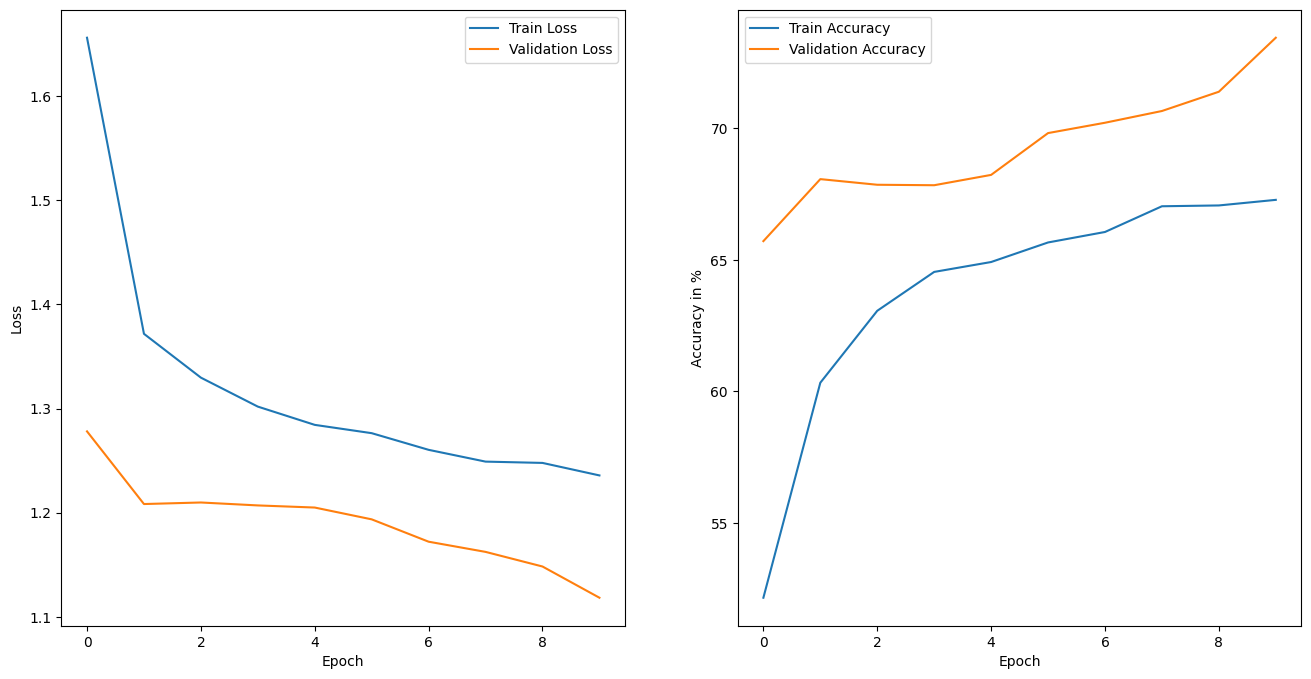

In [18]:
torch.save(model_trained, './model/vgg.pth')
plot_loss_acc(history)

In [31]:
def evaluate(model, data):
    y = []
    y_pred = []
    model.eval()
    
    with tqdm(data, unit='batch', position=0, leave=True) as pbar:
        for img, lbl in pbar:

            pbar.set_description(f"Evaluating")

            img = img.to(device)
            lbl = lbl.to(device)
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            y = y + [*np.array(lbl.cpu())]
            y_pred = y_pred + [*np.array(preds.cpu())]
            # running_loss += loss.item()
            # running_corrects += torch.sum(preds == lbl.data)
            # pbar.set_postfix(loss=loss.item() / BATCH_SIZE, accuracy=torch.sum(preds == lbl.data).item() / BATCH_SIZE)
    
    print(classification_report(y, y_pred))

In [34]:
PATH = './model/vgg.pth'
vgg = torch.load(PATH)
evaluate(vgg, dataloaders['Others']['validation'])

  0%|          | 0/56 [00:00<?, ?batch/s]

              precision    recall  f1-score   support

           0       0.48      0.45      0.46       960
           1       1.00      0.08      0.15       111
           2       0.46      0.27      0.34      1018
           3       0.72      0.85      0.78      1825
           4       0.52      0.62      0.56      1216
           5       0.46      0.48      0.47      1139
           6       0.73      0.68      0.70       797

    accuracy                           0.58      7066
   macro avg       0.62      0.49      0.50      7066
weighted avg       0.58      0.58      0.57      7066



In [32]:
PATH = './model/resnet.pth'
vgg = torch.load(PATH)
evaluate(vgg, dataloaders['Others']['validation'])

  0%|          | 0/56 [00:00<?, ?batch/s]

              precision    recall  f1-score   support

           0       0.35      0.10      0.15       960
           1       0.00      0.00      0.00       111
           2       0.21      0.06      0.09      1018
           3       0.33      0.88      0.48      1825
           4       0.36      0.33      0.34      1216
           5       0.41      0.17      0.24      1139
           6       0.00      0.00      0.00       797

    accuracy                           0.33      7066
   macro avg       0.24      0.22      0.19      7066
weighted avg       0.29      0.33      0.26      7066



c:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\moham\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [33]:
PATH = './model/model.pth'
cnn = torch.load(PATH)
evaluate(cnn, dataloaders['Model']['validation'])

  0%|          | 0/56 [00:00<?, ?batch/s]

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       960
           1       0.77      0.37      0.50       111
           2       0.54      0.29      0.38      1018
           3       0.83      0.89      0.86      1825
           4       0.56      0.63      0.59      1216
           5       0.48      0.60      0.53      1139
           6       0.72      0.78      0.75       797

    accuracy                           0.64      7066
   macro avg       0.64      0.58      0.59      7066
weighted avg       0.64      0.64      0.63      7066

